In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib
import random as rand
from matplotlib import pyplot as plt
from itertools import product
import itertools
import time
import re
import csv
from hurst import compute_Hc
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox
import scipy.stats as ss
import statsmodels.api as sm
import tqdm

%matplotlib inline

/Users/kirillmansurov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
plt.rcParams["axes.labelsize"] = 16. 
plt.rcParams["xtick.labelsize"] = 14. 
plt.rcParams["ytick.labelsize"] = 14. 
plt.rcParams["legend.fontsize"] = 12. 
plt.rcParams["figure.figsize"] = [17., 8.]

------
### First, lets import real data

In [3]:
data_real = pd.read_csv('data/Bitfinex_BTCUSD_minute.csv')
data_real.head(5)

data_default = pd.read_csv('data/params_search/params_214_default.csv')
data_ddpg = pd.read_csv('data/params_search/params_214_ddpg.csv')

/var/folders/xj/25qks7813w5b5f8yn14ggks80000gn/T/ipykernel_1960/1798840052.py:1: DtypeWarning: Columns (0,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_real = pd.read_csv('data/Bitfinex_BTCUSD_minute.csv')


In [4]:
data_real = data_real.reset_index()
data_real.columns = data_real.iloc[0].values
data_real = data_real.iloc[1:]

In [5]:
data_real

,unix,date,symbol,open,high,low,close,Volume USD,Volume BTC
1,1644646260000,2022-02-12 06:11:00,BTC/USD,42282.0,42282.0,42272.0,42282.0,10761.2425584,0.2545112
2,1644646200000,2022-02-12 06:10:00,BTC/USD,42268.38334269,42282.0,42268.38334269,42282.0,450.46819980000004,0.010653900000000001
3,1644646140000,2022-02-12 06:09:00,BTC/USD,42271.8436389,42281.35945349,42245.0,42263.19289836,154149.9029593919,3.64737949
4,1644646080000,2022-02-12 06:08:00,BTC/USD,42290.12693167,42290.12693167,42252.0,42266.65319458,15620.46081579595,0.36956938
5,1644646020000,2022-02-12 06:07:00,BTC/USD,42280.0,42298.0,42280.0,42296.0,3552.26085904,0.08398574
...,...,...,...,...,...,...,...,...,...
644482,1605473040000,2020-11-15 20:44:00,BTC/USD,15855.0,15856.0,15855.0,15855.0,554.925,0.035
644483,1605472980000,2020-11-15 20:43:00,BTC/USD,15854.344656,15857.0,15853.0,15855.0,649.973,0.041
644484,1605472920000,2020-11-15 20:42:00,BTC/USD,15853.389172,15854.0,15853.0,15853.0,586.561,0.037
644485,1605472860000,2020-11-15 20:41:00,BTC/USD,15852.0,15852.735754,15849.0,15850.0,7180.287699,0.453044


In [6]:
data_real['close'] = data_real['close'].apply(float)

Curtosis

In [7]:
kurt_list_real = [pd.DataFrame(data_real.close).pct_change(k).kurt() for k in range(3000)]
kurt_list_ddpg = [pd.DataFrame(data_ddpg.price).pct_change(k).kurt() for k in range(3000)]
kurt_list_default= [pd.DataFrame(data_default.price).pct_change(k).kurt() for k in range(3000)]

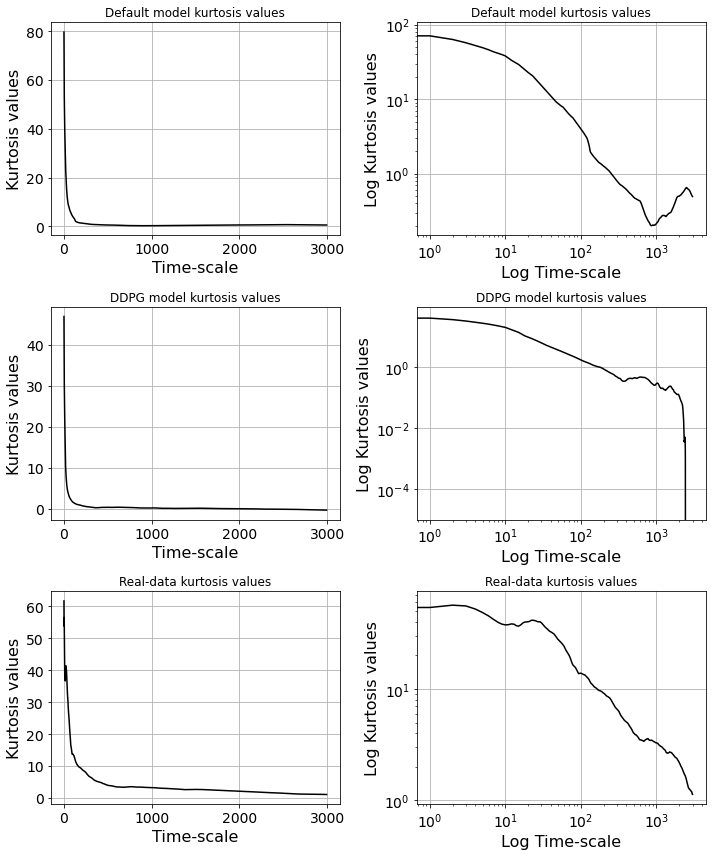

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axs[0, 0].plot(kurt_list_default[5:], color='black')
axs[0, 0].grid()
axs[0, 0].set_title('Default model kurtosis values')
axs[0, 0].set_xlabel('Time-scale')
axs[0, 0].set_ylabel('Kurtosis values')

axs[0, 1].plot(kurt_list_default[5:], color='black')
axs[0, 1].grid()
axs[0, 1].set_title('Default model kurtosis values')
axs[0, 1].set_xlabel('Log Time-scale')
axs[0, 1].set_ylabel('Log Kurtosis values')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')


axs[1, 0].plot(kurt_list_ddpg[5:], color='black')
axs[1, 0].grid()
axs[1, 0].set_title('DDPG model kurtosis values')
axs[1, 0].set_xlabel('Time-scale')
axs[1, 0].set_ylabel('Kurtosis values')

axs[1, 1].plot(kurt_list_ddpg[5:], color='black')
axs[1, 1].grid()
axs[1, 1].set_title('DDPG model kurtosis values')
axs[1, 1].set_xlabel('Log Time-scale')
axs[1, 1].set_ylabel('Log Kurtosis values')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')


axs[2, 0].plot(kurt_list_real[5:], color='black')
axs[2, 0].grid()
axs[2, 0].set_title('Real-data kurtosis values')
axs[2, 0].set_xlabel('Time-scale')
axs[2, 0].set_ylabel('Kurtosis values')

axs[2, 1].plot(kurt_list_real[5:], color='black')
axs[2, 1].grid()
axs[2, 1].set_title('Real-data kurtosis values')
axs[2, 1].set_xlabel('Log Time-scale')
axs[2, 1].set_ylabel('Log Kurtosis values')
axs[2, 1].set_xscale('log')
axs[2, 1].set_yscale('log')

plt.tight_layout()
#plt.show()
plt.savefig('kurt_comp_3.png')

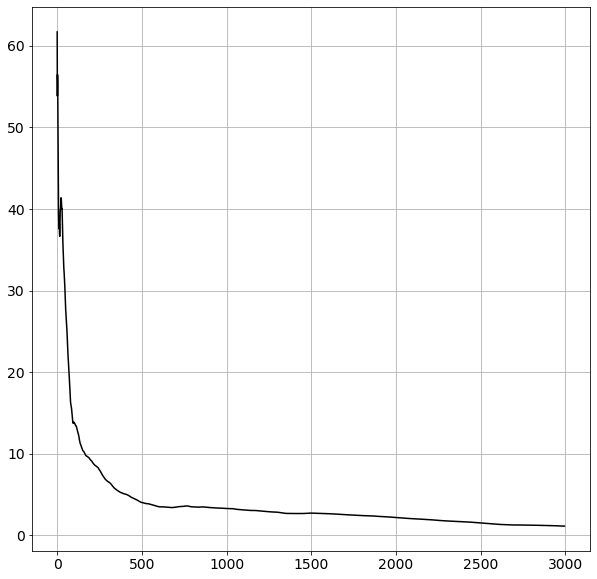

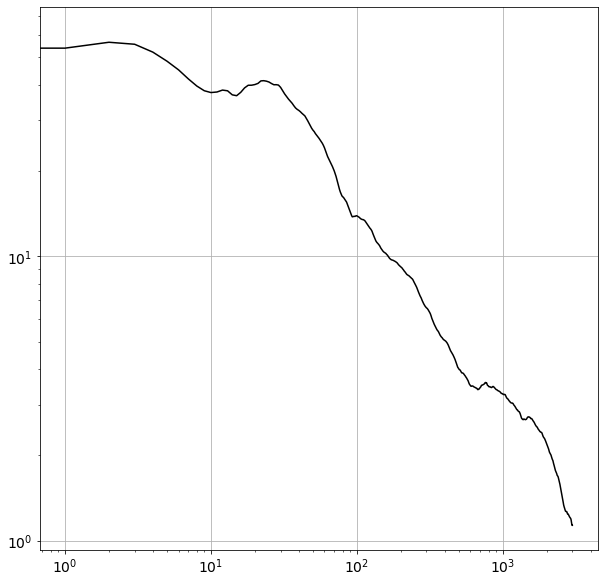

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(kurt_list_real[5:], color='black')
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(kurt_list_real[5:], color='black')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [31]:
data_returns = data_real['close'].pct_change()

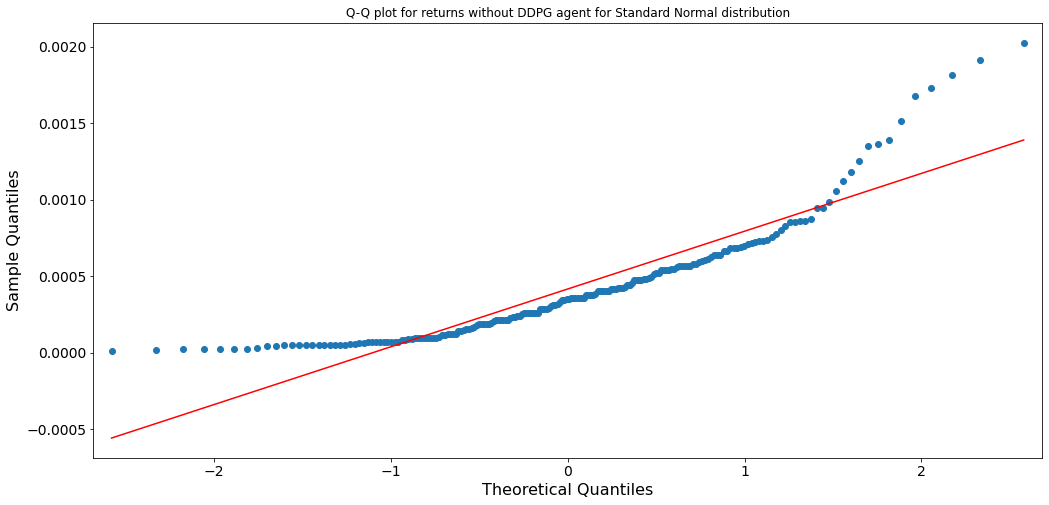

In [43]:
sm.qqplot(data_returns[data_returns>0][:200], line = 's')
plt.title('Q-Q plot for returns without DDPG agent for Standard Normal distribution')
plt.show()

In [66]:
data_ddpg['price'].pct_change()[data_ddpg['price'].pct_change()>0].iloc[:200]

1        7.974482e-05
23       7.243249e-04
39       4.164900e-04
41       1.776357e-15
65       1.073268e-04
             ...     
20449    2.507698e-04
20580    5.191235e-04
20674    1.654130e-04
20703    2.505354e-04
20762    2.648144e-04
Name: price, Length: 200, dtype: float64

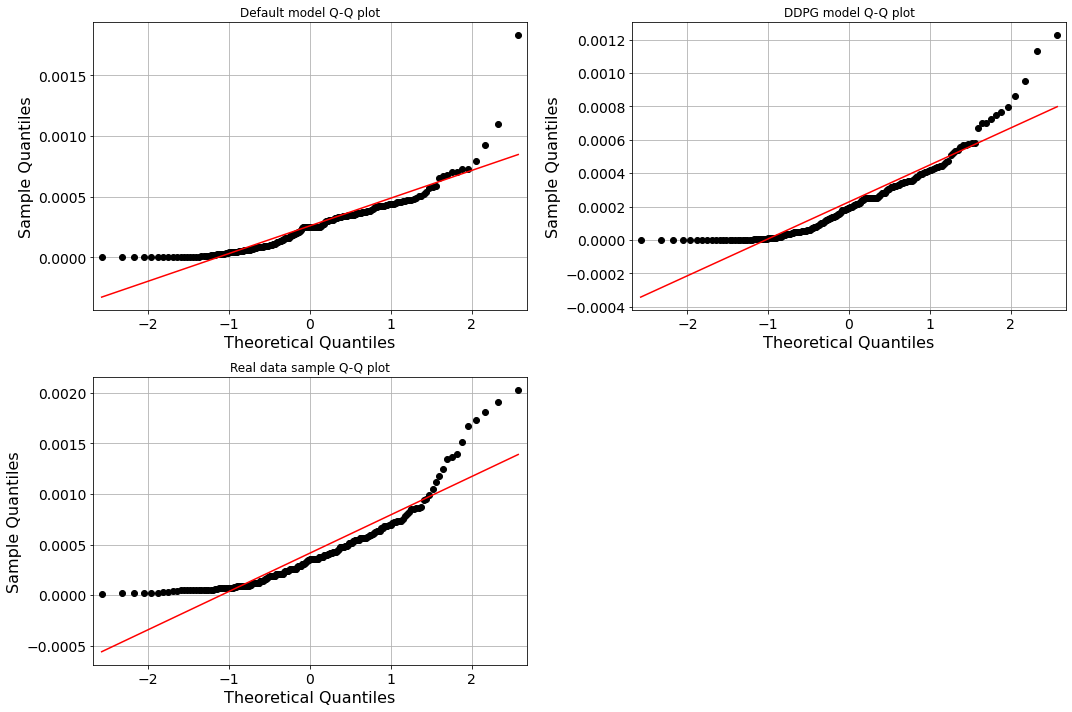

In [95]:
ddpg_pct = data_ddpg['price'].pct_change()
default_pct = data_default['price'].pct_change()


fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 2)
sm.graphics.qqplot(ddpg_pct[ddpg_pct>0].iloc[:200], line='s', 
                   ax=ax, markerfacecolor='k', markeredgecolor='k')
ax.set_title('DDPG model Q-Q plot')
plt.grid()
#top = ax.get_ylim()[1] * 0.75
#txt = ax.text(left, top, 'no keywords', verticalalignment='top')
#txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(2, 2, 3)
sm.graphics.qqplot(data_returns[data_returns>0][:200], line='s', 
                   ax=ax, markerfacecolor='k', markeredgecolor='k')
ax.set_title('Real data sample Q-Q plot')
plt.grid()

ax = fig.add_subplot(2, 2, 1)
sm.graphics.qqplot(default_pct[default_pct>0][:200], line='s', 
                   ax=ax, color='black', markerfacecolor='k', markeredgecolor='k')
ax.set_title('Default model Q-Q plot')
plt.grid()

plt.tight_layout()
plt.savefig('qq_3.png')
#top = ax.get_ylim()[1] * 0.75
#txt = ax.text(, top, "line='s'", verticalalignment='top')
#txt.set_bbox(dict(facecolor='k', alpha=0.1))

In [101]:
gauss_kern = lambda u: 1/np.sqrt(2*np.pi)*np.exp(-u**2/2)
epanch_kern = lambda u: 0.75*max(1-u**2, 0)

def kernel_decomposition(x, X, kern = gauss_kern, h = 0.1):
    return np.mean([1/h*kern((x-k)/h) for k in X])

In [135]:
data_real_norm = np.sort(np.diff(data_real['close'].iloc[:5000]))
data_ddpg_norm = np.sort(np.diff(data_ddpg['price'].iloc[:5000]))
data_default_norm = np.sort(np.diff(data_default['price'].iloc[:5000]))

In [136]:
gauss_ass_real = [kernel_decomposition(x, data_real_norm, kern = gauss_kern, h = 0.1) for x in np.arange(-1, 1, 0.001)]
gauss_ass_ddpg = [kernel_decomposition(x, data_ddpg_norm, kern = gauss_kern, h = 0.1) for x in np.arange(-1, 1, 0.001)]
gauss_ass_default = [kernel_decomposition(x, data_default_norm, kern = gauss_kern, h = 0.1) for x in np.arange(-1, 1, 0.001)]

In [147]:
np.std(data_default_norm)

0.005184910335032282

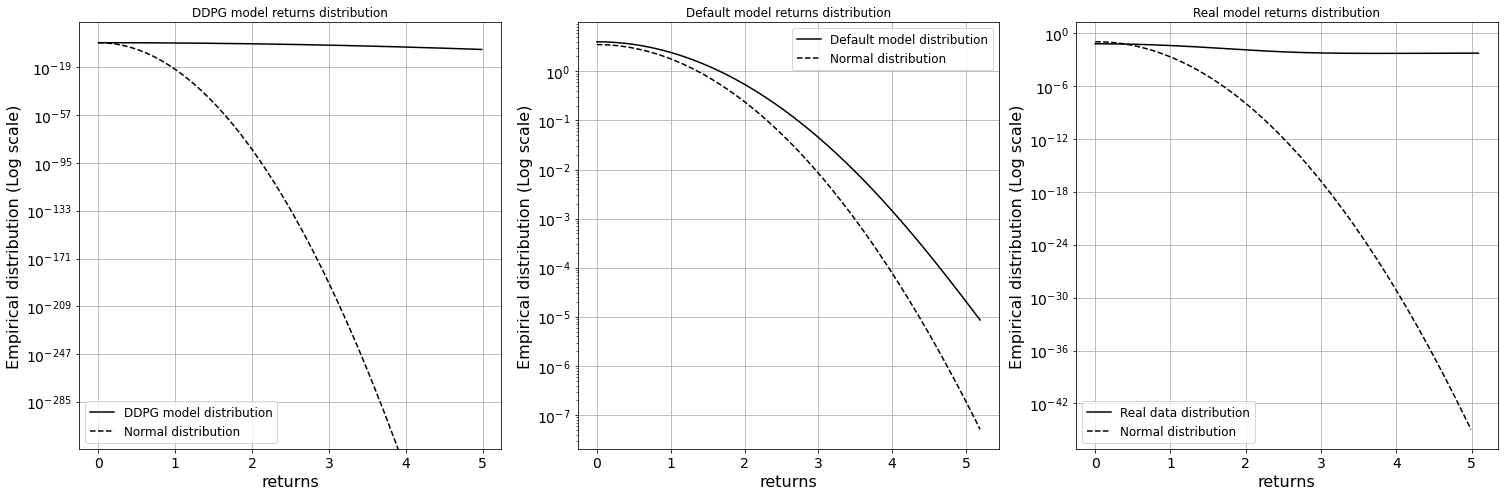

In [163]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs[0].plot(np.arange(0, 10, 0.01)[:500], gauss_ass_ddpg[1000:][:500], label = 'DDPG model distribution', color = 'black')
axs[0].plot(np.arange(0, 10, 0.01)[:420], ss.norm.pdf(np.arange(0, 10, 0.01)[:420], 
                                                      loc = np.mean(data_ddpg_norm), 
                                                      scale = np.std(data_ddpg_norm)*20), 
            label = 'Normal distribution', color = 'black', linestyle = 'dashed')
axs[0].set_title('DDPG model returns distribution')
axs[0].set_xlabel('returns')
axs[0].set_ylabel('Empirical distribution (Log scale)')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(np.arange(0, 10, 0.01)[:520], np.array(gauss_ass_default)[1000:][:520], label = 'Default model distribution', color = 'black')
axs[1].plot(np.arange(0, 10, 0.01)[:520], ss.norm.pdf(np.arange(0, 0.06, 0.00006)[:520], 
                                                      loc = np.mean(data_default_norm), 
                                                      scale = np.std(data_default_norm))/22., 
            label = 'Normal distribution', color = 'black', linestyle='dashed')
axs[1].set_title('Default model returns distribution')
axs[1].set_xlabel('returns')
axs[1].set_ylabel('Empirical distribution (Log scale)')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(np.arange(0, 10, 0.01)[:510], np.array(gauss_ass_real)[1000:][:510], label = 'Real data distribution', color = 'black')
axs[2].plot(np.arange(0, 10, 0.01)[:500], ss.norm.pdf(np.arange(0, 10, 0.01)[:500], 
                                                      loc = np.mean(gauss_ass_real), 
                                                      scale = np.std(gauss_ass_real)*20)/10, 
            label = 'Normal distribution', color = 'black', linestyle = 'dashed')
axs[2].set_title('Real model returns distribution')
axs[2].set_xlabel('returns')
axs[2].set_ylabel('Empirical distribution (Log scale)')
axs[2].set_yscale('log')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()

plt.show()
fig.savefig('empirical_dist_comparing')

In [166]:
### !!!!!!!!!!!!
### Be careful!
from tqdm import tqdm

def Hill_estimator(data):
    ordered = np.sort(data)
    n = ordered.shape[0]

    Hill_est = []
    log_row = np.log(ordered)

    for k in tqdm(range(0, n-1)):
        summ = 1/(k+1)*np.sum([(log_row[-1-i]-log_row[-2-k]) for i in range(k+1)])
        
        Hill_est.append(summ)
    print('done!')
    kappa = 1. / np.array(Hill_est)
    return kappa

In [170]:
data_real_norm = np.sort(np.diff(data_real['close'].iloc[:10000]))
data_ddpg_norm = np.sort(np.diff(data_ddpg['price'].iloc[:10000]))
data_default_norm = np.sort(np.diff(data_default['price'].iloc[:10000]))

Hill_estimator_ddpg = Hill_estimator(data_ddpg_norm)
Hill_estimator_default = Hill_estimator(data_default_norm)

/var/folders/xj/25qks7813w5b5f8yn14ggks80000gn/T/ipykernel_1960/695911231.py:10: RuntimeWarning: divide by zero encountered in log
  log_row = np.log(ordered)
/var/folders/xj/25qks7813w5b5f8yn14ggks80000gn/T/ipykernel_1960/695911231.py:10: RuntimeWarning: invalid value encountered in log
  log_row = np.log(ordered)
  0%|                                                  | 0/9998 [00:00<?, ?it/s]/var/folders/xj/25qks7813w5b5f8yn14ggks80000gn/T/ipykernel_1960/695911231.py:13: RuntimeWarning: invalid value encountered in double_scalars
  summ = 1/(k+1)*np.sum([(log_row[-1-i]-log_row[-2-k]) for i in range(k+1)])
100%|██████████████████████████████████████| 9998/9998 [00:46<00:00, 216.63it/s]


done!


100%|██████████████████████████████████████| 9998/9998 [00:45<00:00, 219.97it/s]

done!


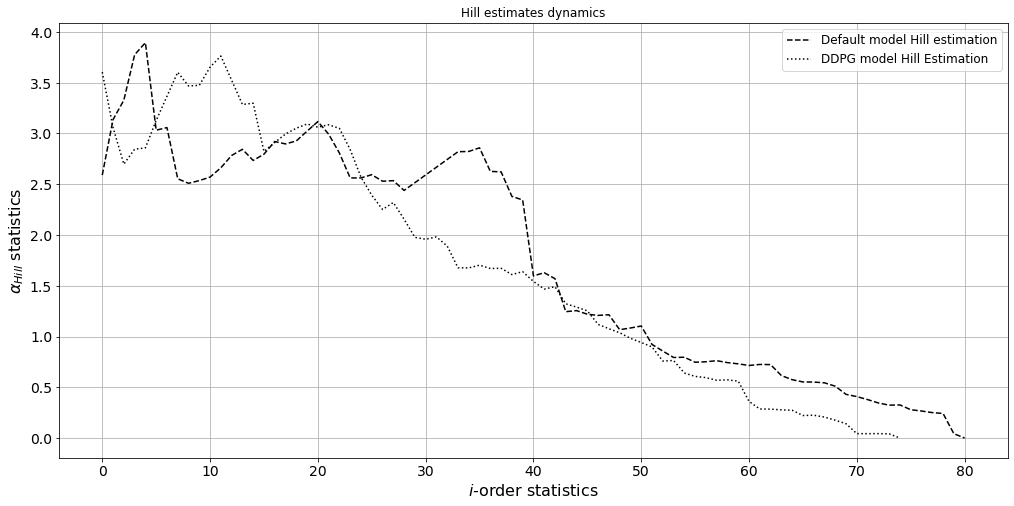

In [172]:
fig, axs = plt.subplots(1, 1)
axs.plot(Hill_estimator_default[3:1214], label = 'Default model Hill estimation', color = 'black', linestyle = 'dashed')
axs.plot(Hill_estimator_ddpg[5:1420], label = 'DDPG model Hill Estimation', color = 'black', linestyle = ':')
axs.legend()
axs.set_xlabel('$i$-order statistics')
axs.set_ylabel(r'$\alpha_{Hill}$ statistics')
axs.set_title('Hill estimates dynamics')
axs.grid(True)
plt.show()
fig.savefig('Hill_estimates')

In [188]:
Hill_estimator_real = Hill_estimator(data_real_norm)

/var/folders/xj/25qks7813w5b5f8yn14ggks80000gn/T/ipykernel_1960/695911231.py:10: RuntimeWarning: divide by zero encountered in log
  log_row = np.log(ordered)
/var/folders/xj/25qks7813w5b5f8yn14ggks80000gn/T/ipykernel_1960/695911231.py:10: RuntimeWarning: invalid value encountered in log
  log_row = np.log(ordered)
 48%|██████████████████                    | 4753/9998 [00:03<00:07, 747.38it/s]/var/folders/xj/25qks7813w5b5f8yn14ggks80000gn/T/ipykernel_1960/695911231.py:13: RuntimeWarning: invalid value encountered in double_scalars
  summ = 1/(k+1)*np.sum([(log_row[-1-i]-log_row[-2-k]) for i in range(k+1)])
100%|██████████████████████████████████████| 9998/9998 [00:15<00:00, 664.56it/s]

done!


In [191]:
Hill_estimator_real[2]

2.9004329098786665

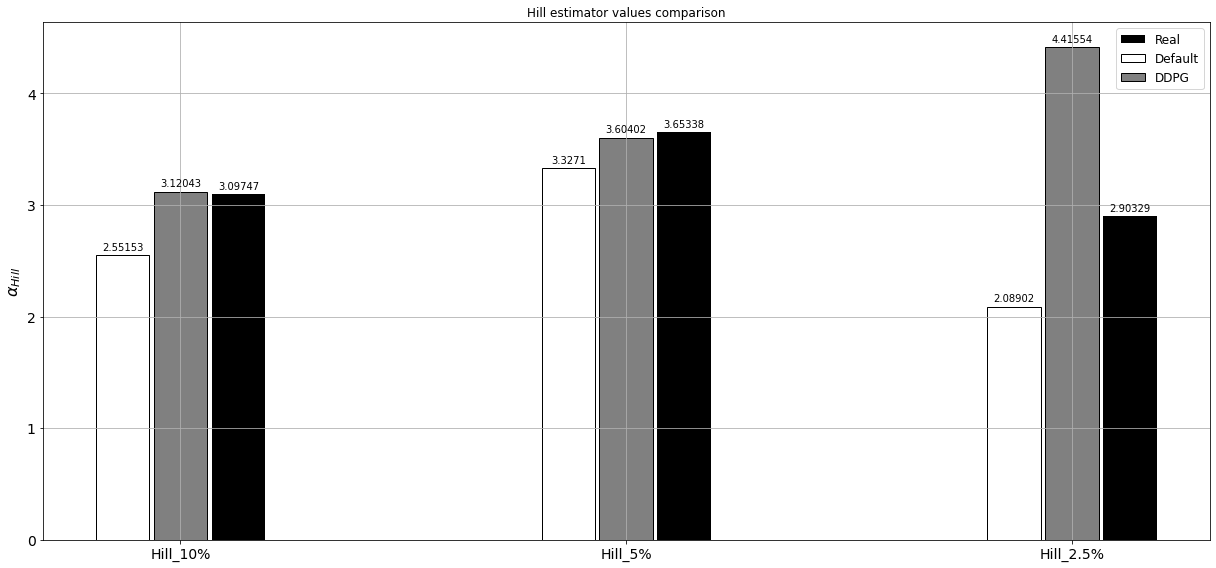

In [196]:
labels = ['Hill_10%', 'Hill_5%', 'Hill_2.5%']

real_estimator = [3.09746511, 3.653382963, 2.9032938]
default_estimator = [2.55153480474, 3.3270975749, 2.089018224486]
ddpg_estimator = [3.120433108664754, 3.604022247, 4.415538940366847]

x = np.arange(len(labels))  # the label locations
width = 0.12  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x + width+0.01, real_estimator, width, label='Real', color = 'black')
rects2 = ax.bar(x - width-0.01, default_estimator, width, label='Default', color = 'white', edgecolor = 'black')
rects3 = ax.bar(x, ddpg_estimator, width, label='DDPG', color = 'gray', edgecolor = 'black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\alpha_{Hill}$')
ax.set_title('Hill estimator values comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding = 3)

fig.tight_layout()

ax.grid(True)
#plt.show()
fig.savefig('Hill_bar')